# <center>ASL Recognition Model</center>

### Initialization

In [1]:
import zipfile

# give permissions to kaggle API
! pip install kaggle
! mkdir /root/.kaggle
! cp kaggle.json /root/.kaggle
! chmod 600 /root/.kaggle/kaggle.json


[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
The syntax of the command is incorrect.
'cp' is not recognized as an internal or external command,
operable program or batch file.
'chmod' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
# download dataset from kaggle to colab
! kaggle datasets download -d grassknoted/asl-alphabet

# extract the content of the zipped file
zip_ref = zipfile.ZipFile('asl-alphabet.zip', 'r')
zip_ref.extractall('/content/')
zip_ref.close()

Dataset URL: https://www.kaggle.com/datasets/grassknoted/asl-alphabet
License(s): GPL-2.0
asl-alphabet.zip: Skipping, found more recently modified local copy (use --force to force download)


### Modules & Libraries

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg

from scipy import stats
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix



import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.optimizers import Optimizer


from tensorflow.keras.optimizers import AdamW

from tensorflow.keras import Sequential
from tensorflow.keras.applications import VGG16, InceptionV3, ResNet50V2, DenseNet121
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPool2D, Activation, GlobalAveragePooling2D, BatchNormalization

import os
import cv2
import glob
import pickle
import random
import warnings


# drive.mount('/content/gdrive')
warnings.filterwarnings('ignore')
%matplotlib inline

### Exploratory Data Analysis

In [4]:
batch_size = 32
img_height = 128
img_width = 128
epochs = 6
num_classes = 27
img_channels = 3

In [5]:
# Define the path to the main folder
import os
import shutil

# Define the main folder path
main_folder_path = r'C:\Users\niraj\Downloads\archive\ASL_Alphabet_Dataset\asl_alphabet_train'

# Remove specific folders if they exist
folders_to_remove = ['del', 'nothing']

for folder in folders_to_remove:
    folder_path = os.path.join(main_folder_path, folder)
    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)  # Deletes the folder and its contents
        print(f"Deleted: {folder_path}")

# Get a list of subfolders within the main folder
subfolders = os.listdir(main_folder_path)

print("Remaining subfolders:", subfolders)


Remaining subfolders: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'space', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


#### Visualization of image from each class

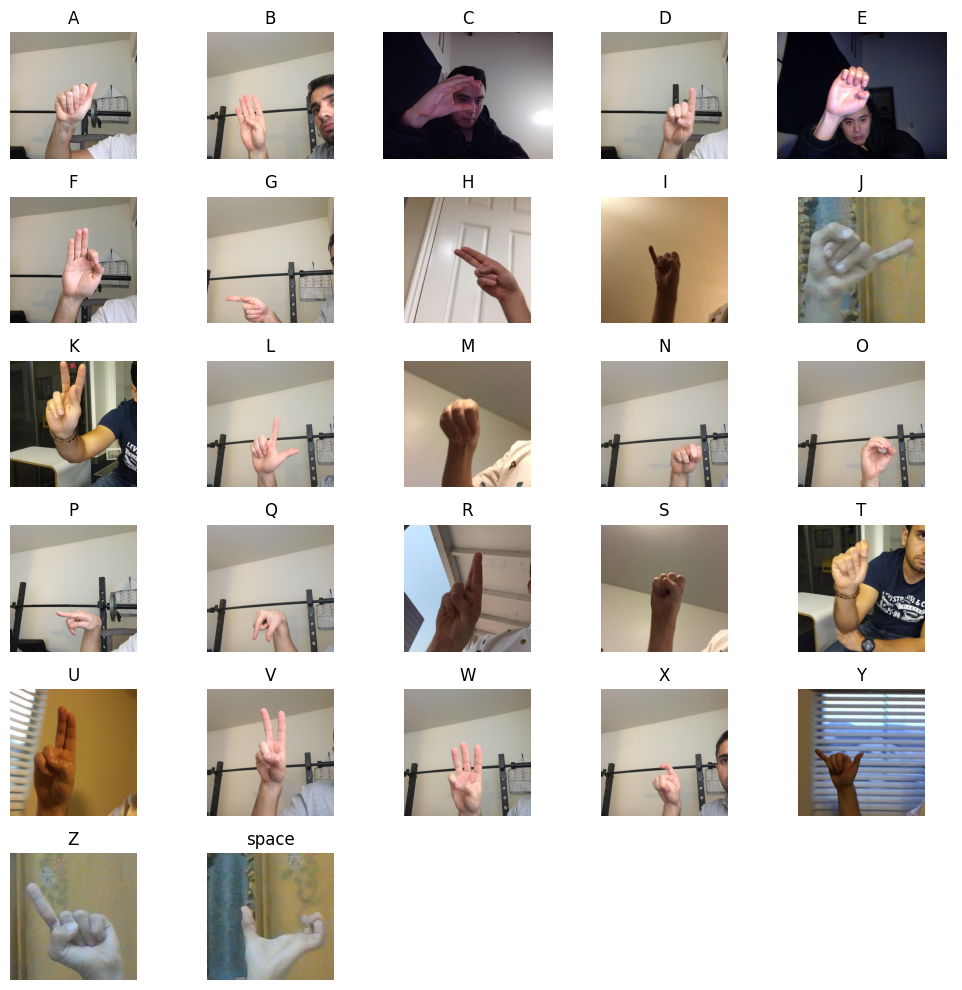

In [6]:
categories = {}
label = []
count = []

# Create a figure to display the images
rows = 6
columns = 5
fig, axs = plt.subplots(rows, columns, figsize=(10, 10))
ax = axs.ravel()

# Iterate through each subfolder and display the first image
for index, subfolder in enumerate(sorted(subfolders)):
    plt.xticks([])
    plt.yticks([])

    categories[index] = subfolder

    # print('subfolder', subfolder, i)
    subfolder_path = os.path.join(main_folder_path, subfolder)
    image_files = os.listdir(subfolder_path)

    count.append(len(image_files))
    label.append(subfolder)

    # Load the first image in the subfolder
    image_path = os.path.join(subfolder_path, image_files[0])
    img = mimg.imread(image_path)

    # Display the image using plt.imshow
    ax[index].imshow(img)
    ax[index].set_title(subfolder)
    ax[index].axis('off')

ax[index+1].set_axis_off()
ax[index+2].set_axis_off()
ax[index+3].set_axis_off()



# Adjust the layout and display the figure
plt.tight_layout()
plt.show()

df = pd.DataFrame({'Label': label, 'Count': count})

#### Visualization of number of images in each class

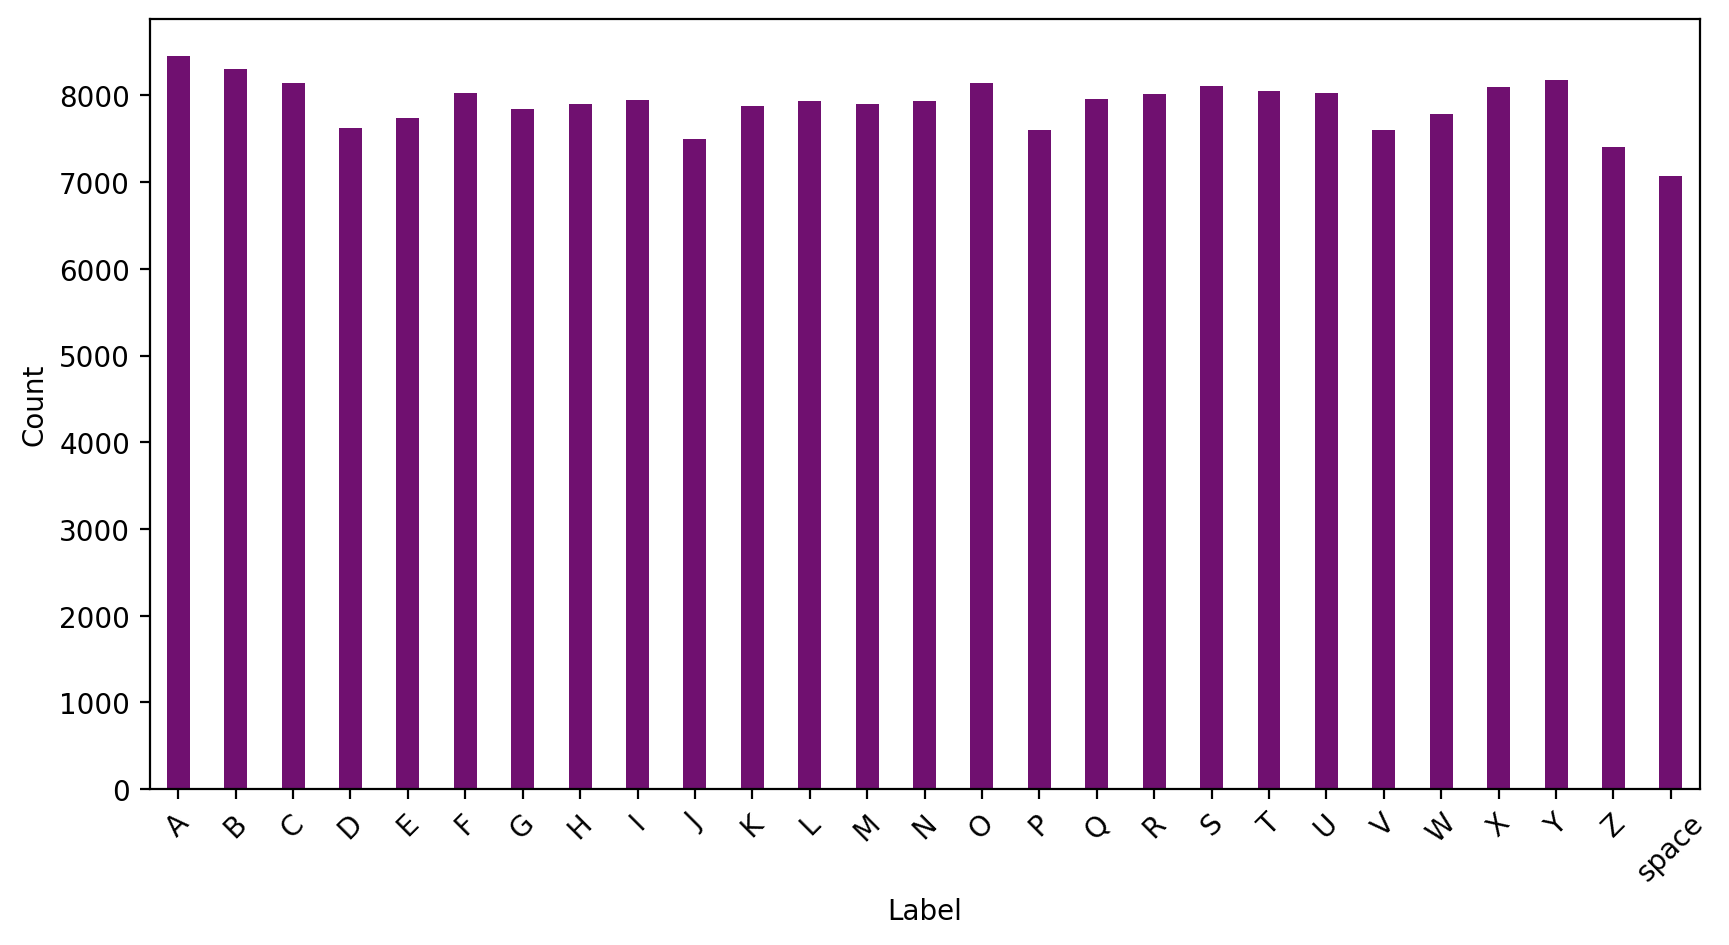

In [7]:
plt.figure(figsize=(10, 5), dpi=200)
# plt.title('Class distribution in Dataset',fontsize=15)

sns.barplot(data=df, x='Label', y='Count', width=0.4, color='purple')

plt.xticks(rotation = 45)
plt.show()

In [8]:
df['Count'].min(), df['Count'].max()

(7071, 8458)

Since there are 3000 images in each clas, we can conclude that the dataset is balanced.

In [9]:
categories

{0: 'A',
 1: 'B',
 2: 'C',
 3: 'D',
 4: 'E',
 5: 'F',
 6: 'G',
 7: 'H',
 8: 'I',
 9: 'J',
 10: 'K',
 11: 'L',
 12: 'M',
 13: 'N',
 14: 'O',
 15: 'P',
 16: 'Q',
 17: 'R',
 18: 'S',
 19: 'T',
 20: 'U',
 21: 'V',
 22: 'W',
 23: 'X',
 24: 'Y',
 25: 'Z',
 26: 'space'}

#### Distribution of dimension of the images

In [10]:
width_dim = []
height_dim = []

def get_dimension():
    sub_dataset_path = 'C:\\Users\\niraj\\Downloads\\archive\\ASL_Alphabet_Dataset\\asl_alphabet_train'

    letters = os.listdir(sub_dataset_path)

    for letter in letters:
        letter_path = os.path.join(sub_dataset_path, letter)

        for image in os.listdir(letter_path):

            image_path = os.path.join(letter_path, image)
            img = mimg.imread(image_path)
            d1, d2, colors = img.shape

            width_dim.append(d1)
            height_dim.append(d2)

get_dimension()

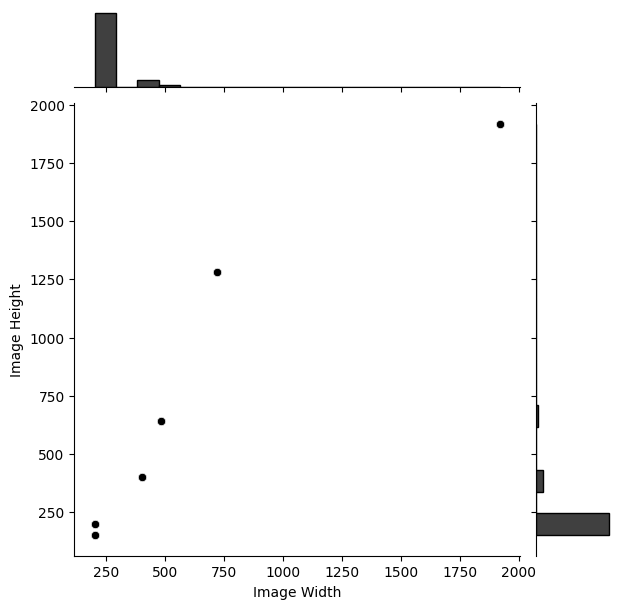

In [11]:
sns.jointplot(x=width_dim, y=height_dim, color='black')
plt.xlabel("Image Width")
plt.ylabel("Image Height")
plt.show()

In [12]:
stats.mode(width_dim), stats.mode(height_dim), 3

(ModeResult(mode=200, count=186616), ModeResult(mode=200, count=186612), 3)

The dimension of each image in the dataset is 200x200.

In [13]:
image_shape = (128, 128, 3)
print(200*200*3)
print(128*128*3)

120000
49152


### Data Preprocessing

In [14]:
# Create dataframe
labels = list(categories.values())

list_path = []
list_labels = []
for label in labels:
    label_path = os.path.join(main_folder_path, label, "*")
    image_files = glob.glob(label_path)

    sign_label = [label] * len(image_files)


    list_path.extend(image_files)
    list_labels.extend(sign_label)

dataframe = pd.DataFrame({
    "image_path": list_path,
    "label": list_labels
})

# dataframe

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    dataframe["image_path"],
    dataframe["label"],
    test_size=0.15,
    random_state=2024,
    shuffle=True,
    stratify = dataframe["label"]
)

train_df = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})

X_train, X_val, y_train, y_val = train_test_split(
    train_df["image_path"], train_df["label"],
    test_size=0.20,
    random_state=2024,
    shuffle=True,
    stratify=train_df["label"]
)

train_df = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})
val_df = pd.DataFrame({
    "image_path": X_val,
    "label": y_val
})
test_df = pd.DataFrame({
    "image_path": X_test,
    "label": y_test
})

In [16]:
datagen = image.ImageDataGenerator(rescale=1./255.,)
# Training Dataset
train_gen = datagen.flow_from_dataframe(
    train_df,
    directory="./",
    x_col="image_path",
    y_col="label",
    batch_size=batch_size,
    class_mode="sparse",


    target_size=(img_height, img_width),
)






# Validation Dataset
val_gen = datagen.flow_from_dataframe(
    val_df,
    directory="./",
    x_col="image_path",
    y_col="label",
    class_mode="sparse",


    batch_size=batch_size,
    target_size=(img_height, img_width),
)

# Testing Dataset
test_gen = datagen.flow_from_dataframe(
    test_df,
    directory="./",
    x_col="image_path",
    y_col="label",
    class_mode="sparse",


    batch_size=1,
    target_size=(img_height, img_width),
    shuffle=False
)

Found 144980 validated image filenames belonging to 27 classes.
Found 36246 validated image filenames belonging to 27 classes.
Found 31982 validated image filenames belonging to 27 classes.


### Model Training

In [17]:
early_stopping = EarlyStopping(monitor='val_loss',
                              min_delta=0.001,
                              patience=5,
                              restore_best_weights=True,
                              verbose=True)

reduce_learning_rate = ReduceLROnPlateau(monitor='val_accuracy',
                                        patience=2,
                                        factor=0.5,
                                        verbose=True)

checkpoint = ModelCheckpoint('best_weights.h5', save_best_only=True, monitor='val_accuracy', mode='max')

**VGG16**

In [18]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, img_channels))

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(27, activation='softmax'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 27)             │        13,851 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,186,011 (73.19 MB)

 Trainable params: 19,186,011 (73.19 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Load VGG16 model and modify for ASL recognition
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, img_channels))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(27, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

display(model.summary())
# display(tf.keras.utils.plot_model(model, to_file='vgg16.png', show_shapes=True))

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 27)             │        13,85

 Total params: 19,186,011 (73.19 MB)

 Trainable params: 4,471,323 (17.06 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

None

In [20]:
model.compile(optimizer=AdamW(learning_rate=0.001, weight_decay=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [22]:
#accuracy started from 0.049
#loss ud reducing severly
#leastning rate is 996ms/step for adamw
 # Train the Model
model.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // batch_size,
    epochs=epochs,
    validation_data=val_gen,
    validation_steps=val_gen.samples // batch_size,
    callbacks=[checkpoint, early_stopping, reduce_learning_rate],
    verbose=True
)

Epoch 1/6
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 0s 615ms/step - accuracy: 0.3706 - loss: 1.9679

4530/4530 ━━━━━━━━━━━━━━━━━━━━ 3439s 759ms/step - accuracy: 0.3706 - loss: 1.9678 - val_accuracy: 0.8630 - val_loss: 0.5363 - learning_rate: 0.0010
Epoch 2/6
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 638s 141ms/step - accuracy: 0.5000 - loss: 1.1443 - val_accuracy: 0.8611 - val_loss: 0.5438 - learning_rate: 0.0010
Epoch 3/6
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.6315 - loss: 1.0809

4530/4530 ━━━━━━━━━━━━━━━━━━━━ 3585s 791ms/step - accuracy: 0.6315 - loss: 1.0808 - val_accuracy: 0.8769 - val_loss: 0.4328 - learning_rate: 0.0010
Epoch 4/6
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 914s 202ms/step - accuracy: 0.7812 - loss: 0.8664 - val_accuracy: 0.8746 - val_loss: 0.4417 - learning_rate: 0.0010
Epoch 5/6
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - accuracy: 0.6887 - loss: 0.9147
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 3570s 788ms/step - accuracy: 0.6887 - loss: 0.9147 - val_accuracy: 0.8717 - val_loss: 0.4385 - learning_rate: 0.0010
Epoch 6/6
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 647s 143ms/step - accuracy: 0.7188 - loss: 0.8662 - val_accuracy: 0.8727 - val_loss: 0.4387 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 3.


## Model Evaluation

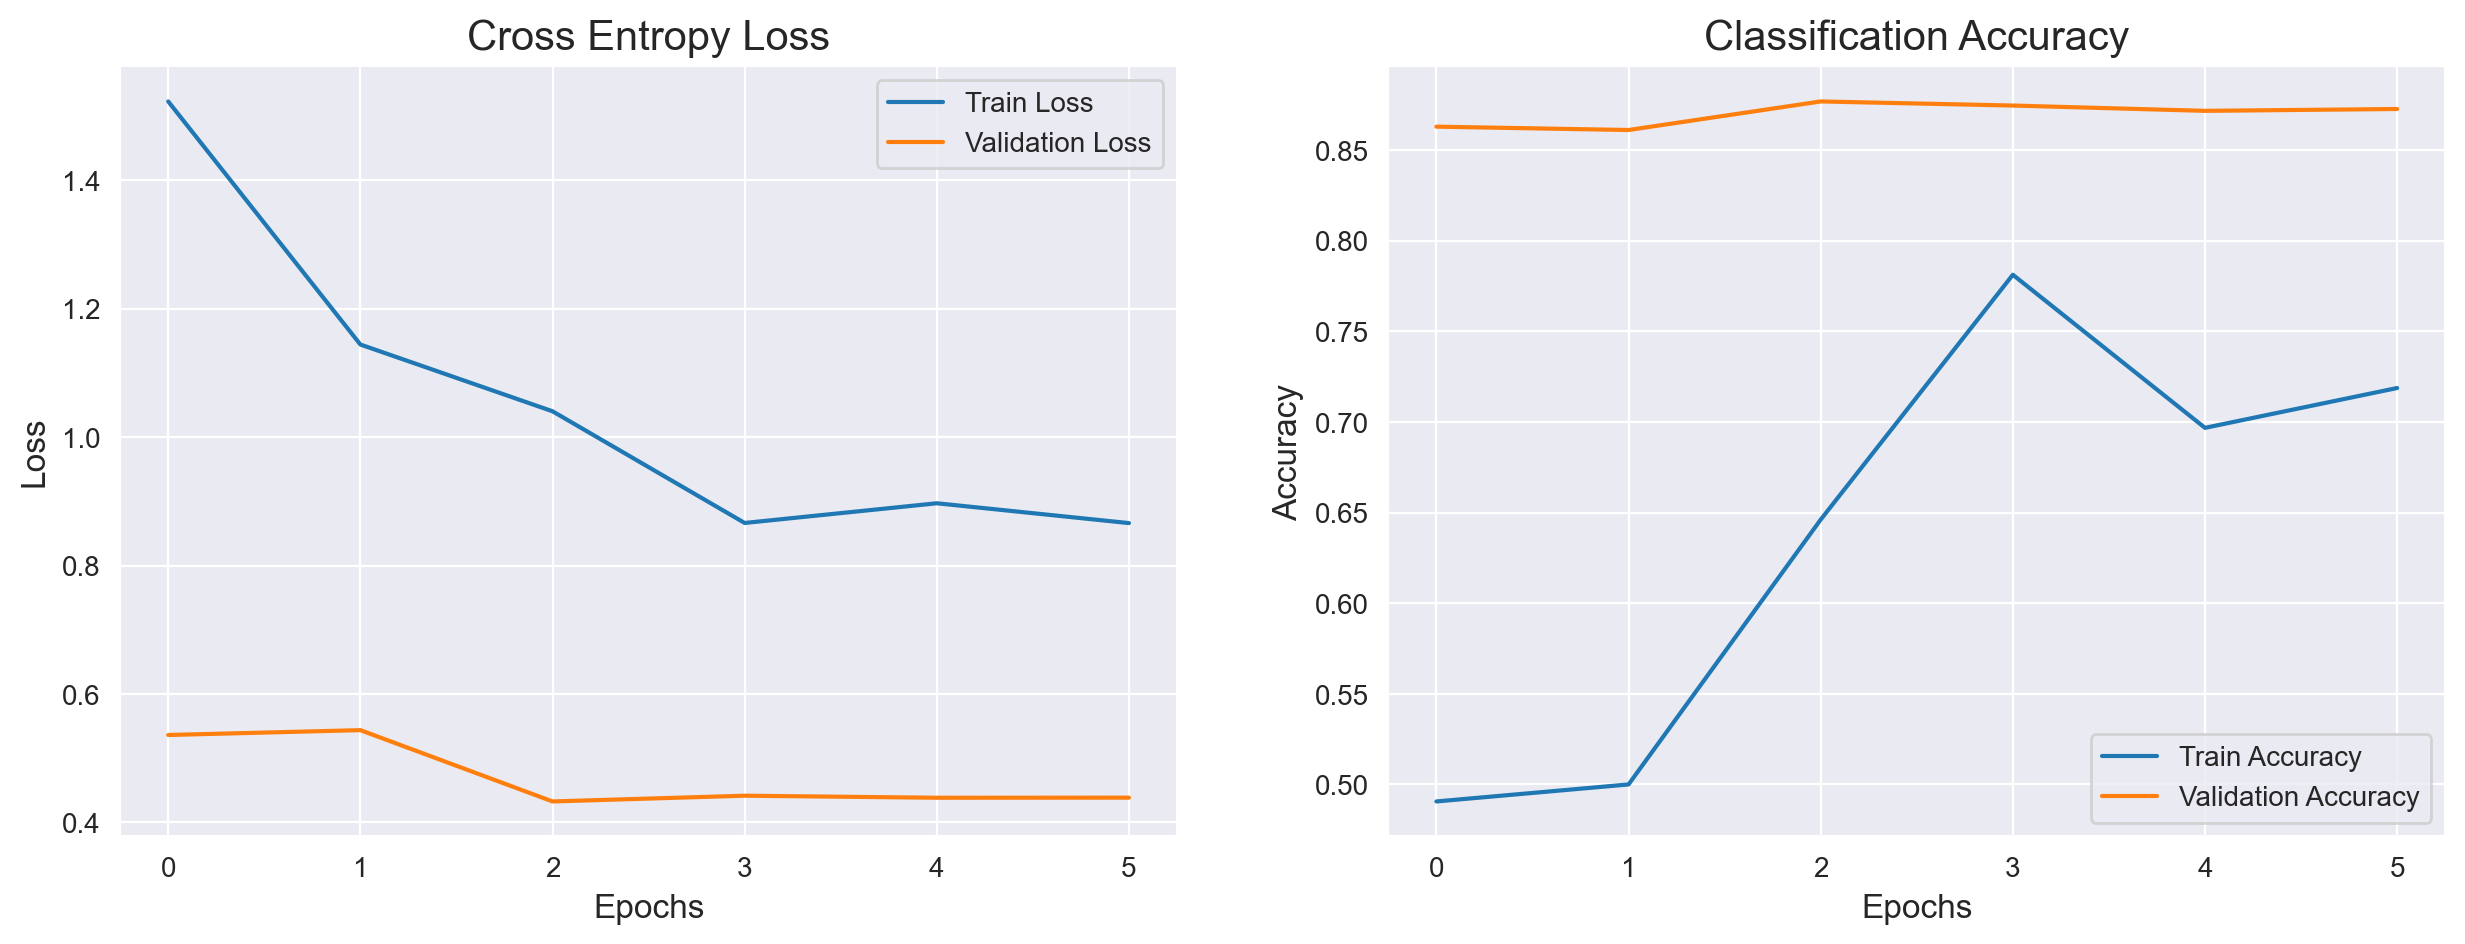

In [23]:
metrics = pd.DataFrame(model.history.history)

plt.figure(figsize=(15,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(metrics['loss'], label='Train Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.legend()

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(metrics['accuracy'], label='Train Accuracy')
plt.plot(metrics['val_accuracy'], label='Validation Accuracy')
plt.legend()

plt.show()

In [24]:
# Evaluate test dataset
loss, acc = model.evaluate(test_gen, verbose=False)

print('The accuracy of the model for testing data is:', acc*100)
print('The Loss of the model for testing data is:', loss)

The accuracy of the model for testing data is: 87.98386454582214
The Loss of the model for testing data is: 0.42525553703308105


In [28]:
predicted_class = model.predict(test_gen, verbose=False)
predicted_class = np.argmax(predicted_class, axis=1)
actual_class = test_gen.labels

correct = np.nonzero(predicted_class == actual_class)[0]
incorrect = np.nonzero(predicted_class != actual_class)[0]

print("Correct predicted classes:", correct.shape[0])
print("Incorrect predicted classes:", incorrect.shape[0])

Correct predicted classes: 28139
Incorrect predicted classes: 3843


In [29]:
print(classification_report(actual_class, predicted_class,
                            target_names=categories.values()))

              precision    recall  f1-score   support

           A       0.90      0.80      0.85      1269
           B       0.96      0.90      0.93      1246
           C       0.96      0.95      0.95      1222
           D       0.95      0.94      0.95      1144
           E       0.82      0.93      0.87      1162
           F       0.99      0.92      0.96      1205
           G       0.74      0.97      0.84      1177
           H       1.00      0.67      0.80      1186
           I       0.82      0.90      0.86      1193
           J       0.94      0.96      0.95      1125
           K       0.98      0.84      0.90      1181
           L       0.94      0.96      0.95      1191
           M       0.90      0.88      0.89      1185
           N       0.99      0.74      0.85      1190
           O       0.98      0.95      0.96      1221
           P       0.96      0.99      0.97      1140
           Q       0.99      0.94      0.97      1193
           R       0.97    

In [30]:
con_matrix = tf.math.confusion_matrix(
        labels=actual_class,
        predictions=predicted_class,
        num_classes=27)

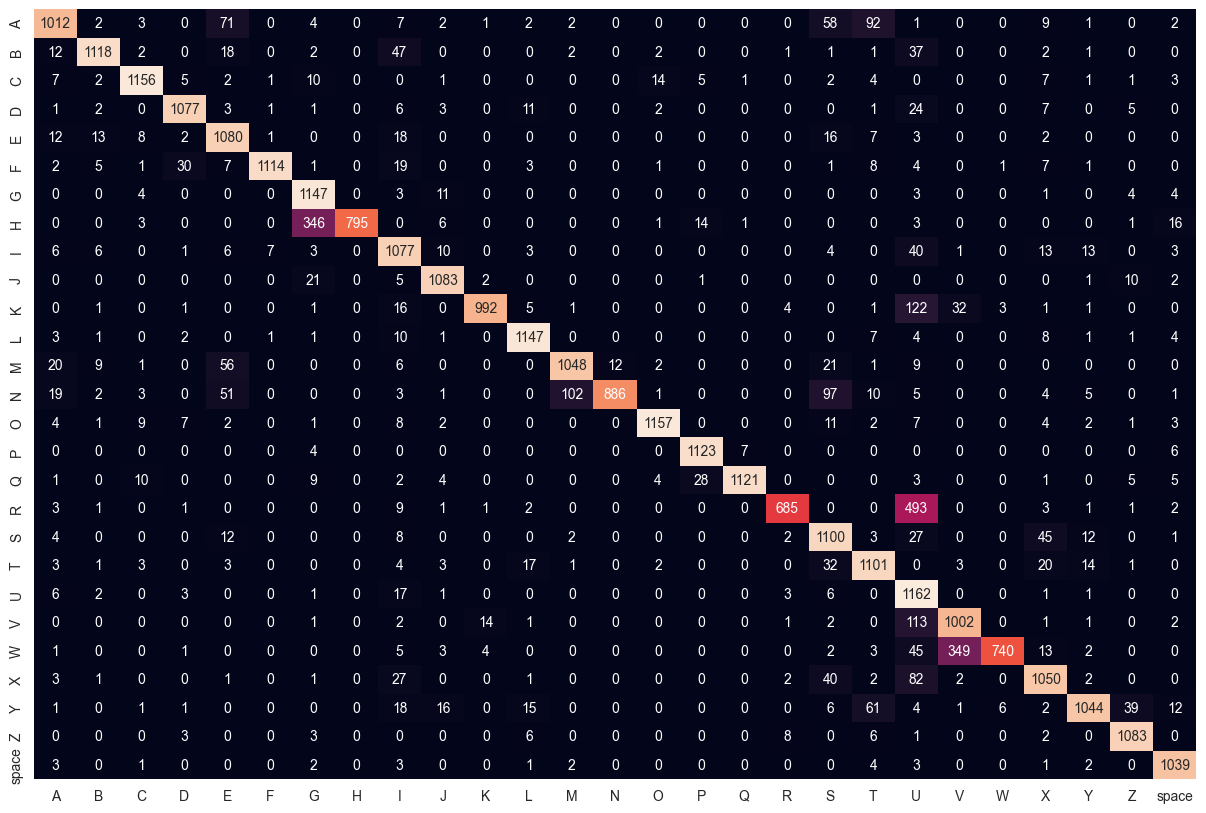

In [31]:
plt.figure(figsize=(15,10))
sns.heatmap(con_matrix, annot=True, fmt='g', cbar=False, xticklabels=categories.values(), yticklabels=categories.values())
plt.show()

In [32]:
test_images = '/content/asl_alphabet_test/asl_alphabet_test'

for i in os.listdir(test_images):
  img = os.path.join(test_images, i)
  print(f'Image: {i}', end='\t\t')
  img = cv2.imread(img, cv2.IMREAD_COLOR)
  img = cv2.resize(img, (128, 128))

  img = image.img_to_array(img)

  img = img / 255.0
  img = np.expand_dims(img, axis=0)

  predict = model.predict(img, verbose=False)
  predict_class = np.argmax(predict, axis=1)

  print("Prediction: ", categories[tuple(predict_class)[0]], end='\n\n')

Image: A_test.jpg		Prediction:  S

Image: B_test.jpg		Prediction:  B

Image: C_test.jpg		Prediction:  C

Image: D_test.jpg		Prediction:  D

Image: E_test.jpg		Prediction:  E

Image: F_test.jpg		Prediction:  F

Image: G_test.jpg		Prediction:  G

Image: H_test.jpg		Prediction:  H

Image: I_test.jpg		Prediction:  I

Image: J_test.jpg		Prediction:  J

Image: K_test.jpg		Prediction:  K

Image: L_test.jpg		Prediction:  L

Image: M_test.jpg		Prediction:  M

Image: nothing_test.jpg		Prediction:  D

Image: N_test.jpg		Prediction:  N

Image: O_test.jpg		Prediction:  O

Image: P_test.jpg		Prediction:  P

Image: Q_test.jpg		Prediction:  Q

Image: R_test.jpg		Prediction:  R

Image: space_test.jpg		Prediction:  space

Image: S_test.jpg		Prediction:  S

Image: T_test.jpg		Prediction:  T

Image: U_test.jpg		Prediction:  U

Image: V_test.jpg		Prediction:  V

Image: W_test.jpg		Prediction:  W

Image: X_test.jpg		Prediction:  X

Image: Y_test.jpg		Prediction:  Y

Image: Z_test.jpg		Prediction:  Z



## Save Model

In [33]:
model.save('vgg16_model7.h5')

## Feature Extraction

In [34]:
fine_tuned_model = load_model("best_weights.h5")

In [35]:
dense_model = Model(inputs=fine_tuned_model.inputs, outputs=fine_tuned_model.layers[-3].output)
dense_model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       262,656 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,172,160 (73.14 MB)

 Trainable params: 4,457,472 (17.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [36]:
import pandas as pd
from tensorflow.keras.preprocessing import image
import numpy as np

# Assuming the dense_model is pre-loaded somewhere
# Example: dense_model = load_model('path_to_dense_model.h5')

# Function to extract features using the dense model
def dense_feature_prediction(img_path):
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img = image.img_to_array(img)
    img = img / 255.
    img = np.expand_dims(img, axis=0)
    dense_feature = dense_model.predict(img, verbose=0)[0]  # Assuming dense_model is loaded
    return dense_feature

# Ensure 'labels' is defined before this loop
labels = test_df["label"].unique()

# Create an empty dataframe to store features
reduction_data = pd.DataFrame()

# Collect data for each label
for label in labels:
    label_data = test_df[test_df["label"] == label][:100]
    reduction_data = pd.concat([reduction_data, label_data], ignore_index=True)

# Reset index for final dataframe
reduction_data = reduction_data.reset_index(drop=True)
display(reduction_data)

# Extract features for each image path
dense_features = reduction_data["image_path"].apply(dense_feature_prediction)

# Convert the extracted features into a dataframe
dense_features_df = pd.DataFrame.from_records(dense_features.values, index=dense_features.index)


,image_path,label
0,C:\Users\niraj\Downloads\archive\ASL_Alphabet_...,A
1,C:\Users\niraj\Downloads\archive\ASL_Alphabet_...,A
2,C:\Users\niraj\Downloads\archive\ASL_Alphabet_...,A
3,C:\Users\niraj\Downloads\archive\ASL_Alphabet_...,A
4,C:\Users\niraj\Downloads\archive\ASL_Alphabet_...,A
...,...,...
2695,C:\Users\niraj\Downloads\archive\ASL_Alphabet_...,E
2696,C:\Users\niraj\Downloads\archive\ASL_Alphabet_...,E
2697,C:\Users\niraj\Downloads\archive\ASL_Alphabet_...,E
2698,C:\Users\niraj\Downloads\archive\ASL_Alphabet_...,E


In [37]:
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd

# Ensure dense_features is a 2D numpy array (num_samples, num_features)
dense_features_array = np.vstack(dense_features.values)

# t-SNE dimensionality reduction
tsne = TSNE(n_components=2, verbose=1, random_state=0, angle=0.99, init='pca')

# Perform t-SNE
tsne_features = tsne.fit_transform(dense_features_array)

# Convert the t-SNE features into a DataFrame
tsne_features = pd.DataFrame(tsne_features, columns=["tsne_feat_0", "tsne_feat_1"])

# Add the t-SNE features to the original dataframe
reduction_data[["tsne_feat_0", "tsne_feat_1"]] = tsne_features

# Display the result
display(reduction_data)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2700 samples in 0.002s...
[t-SNE] Computed neighbors for 2700 samples in 0.554s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2700
[t-SNE] Computed conditional probabilities for sample 2000 / 2700
[t-SNE] Computed conditional probabilities for sample 2700 / 2700
[t-SNE] Mean sigma: 2.310078
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.502350
[t-SNE] KL divergence after 1000 iterations: 0.652828


,image_path,label,tsne_feat_0,tsne_feat_1
0,C:\Users\niraj\Downloads\archive\ASL_Alphabet_...,A,1.254236,-26.403225
1,C:\Users\niraj\Downloads\archive\ASL_Alphabet_...,A,-6.215465,-10.019702
2,C:\Users\niraj\Downloads\archive\ASL_Alphabet_...,A,1.359977,-10.691823
3,C:\Users\niraj\Downloads\archive\ASL_Alphabet_...,A,4.176096,-16.145416
4,C:\Users\niraj\Downloads\archive\ASL_Alphabet_...,A,-1.433964,-23.992794
...,...,...,...,...
2695,C:\Users\niraj\Downloads\archive\ASL_Alphabet_...,E,8.037051,-24.544361
2696,C:\Users\niraj\Downloads\archive\ASL_Alphabet_...,E,8.084971,-24.365795
2697,C:\Users\niraj\Downloads\archive\ASL_Alphabet_...,E,11.686803,-25.254944
2698,C:\Users\niraj\Downloads\archive\ASL_Alphabet_...,E,12.829823,-25.410917


In [38]:
reduction_data.to_csv('dataframe.csv')

In [39]:
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [40]:
# Scatter Plot
list_colors = ["#FF0000", "#00FF00", "#0000FF", "#FFFF00", "#FF00FF", "#00FFFF", "#FF4500", "#800080", "#32CD32", "#8B0000",
               "#000080", "#808000", "#FF6347", "#008080", "#FF1493", "#7FFF00", "#D2691E", "#9400D3", "#B22222", "#ADFF2F",
               "#ADD8E6", "#FF69B4", "#F0E68C", "#4682B4", "#9ACD32", "#800000", "#FFD700", "#20B2AA", "#A52A2A"
              ]
fig = px.scatter(
    reduction_data, x="tsne_feat_0", y="tsne_feat_1", color='label', color_discrete_sequence=list_colors
)

fig.update_traces(marker=dict(size=8),)

# Update Axes
fig.update_xaxes(title="", linecolor="Black", zeroline=False, mirror=True)
fig.update_yaxes(title="", linecolor="Black", zeroline=False, mirror=True)

# Update Layout
fig.update_layout(
    title_text="t-SNE Visualization", title_x=0.5,
    width=900, height=900,
    plot_bgcolor='White',
    coloraxis_showscale=False,
)

# Show
fig.show()

In [41]:
fig.write_html('feat_ext.html')

**CNN**

In [42]:
cnn_model = Sequential()
cnn_model.add(Conv2D(32, (5, 5), input_shape=image_shape)) ##32 filters, 5x5 kernel, input shape is 128x128x3
cnn_model.add(Activation('relu')) ##activation function
cnn_model.add(MaxPool2D((2, 2))) ##pooling layer
cnn_model.add(Conv2D(64, (3, 3))) ##64 filters, 3x3 kernel
cnn_model.add(Activation('relu')) ##activation function
cnn_model.add(MaxPool2D((2, 2))) ##pooling layer
cnn_model.add(Conv2D(64, (3, 3))) ##64 filters, 3x3 kernel
cnn_model.add(Activation('relu')) ##activation function
cnn_model.add(MaxPool2D((2, 2))) ##pooling layer
cnn_model.add(Flatten()) ##flatten the data
cnn_model.add(Dense(128, activation='relu')) ##128 neurons, activation function
cnn_model.add(Dense(27, activation='softmax')) ##output layer, 27 neurons, activation function

display(cnn_model.summary())
display(tf.keras.utils.plot_model(cnn_model, to_file='cnn.png', show_shapes=True))

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 124, 124, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 124, 124, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 60, 60, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 27)             │         3,483 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,667,099 (6.36 MB)

 Trainable params: 1,667,099 (6.36 MB)

 Non-trainable params: 0 (0.00 B)

None

You must install pydot (`pip install pydot`) for `plot_model` to work.


None